# 这一部分演示使用dynamic_rnn实现简单的seq2seq模型
主要参考 github repo [tensorflow-seq2seq-tutorial](https://github.com/ematvey/tensorflow-seq2seq-tutorials)的第一和第二部分

In [1]:
# 产生不定长合成序列的函数
import helpers as data_helpers

## Demo-I：使用dynamic_rnn实现简单的seq2seq模型

### 使用一个合成的minibatch data解释seq2seq模型

### seq2seq模型任务是copy sequence

### 0. 合成数据

**seq2seq模型中的数据特征：不定长度的序列样本**

In [2]:
x = [[5, 7, 8], [6, 3], [3], [1]]
xt, xlen = data_helpers.batch(x)

In [3]:
print('原始的4个序列样本是:\n%s' % x)
print('\npadding以后使用time-major记录的数据array: \n%s' % xt)
print('\npadding以后使用batch-major记录的数据array: \n%s' % xt.T)
print('\npadding以后序列长度是: \n %s' % xlen)

原始的4个序列样本是:
[[5, 7, 8], [6, 3], [3], [1]]

padding以后使用time-major记录的数据array: 
[[5 6 3 1]
 [7 3 0 0]
 [8 0 0 0]]

padding以后使用batch-major记录的数据array: 
[[5 7 8]
 [6 3 0]
 [3 0 0]
 [1 0 0]]

padding以后序列长度是: 
 [3, 2, 1, 1]


**`InteractiveSession`**在 理解tf的函数 和 debug一段代码 方面非常有用

In [4]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [5]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = 2 * encoder_hidden_units # bidirectional RNN, 见后面的解释

## 1. placeholders,模型的数据

In [6]:
with tf.name_scope('minibatch'):
    # encoding 阶段的 placeholder
    encoder_inputs = tf.placeholder(shape=(None, None),
                                    dtype=tf.int32,
                                    name='encoder_inputs')
    encoder_inputs_length = tf.placeholder(shape=(None,),
                                           dtype=tf.int32,
                                           name='encoder_inputs_length')

    # decoding 阶段的placeholder
    decoder_inputs = tf.placeholder(shape=(None, None),
                                    dtype=tf.int32,
                                    name='decoder_inputs')
    
    # decoding 结束后用来计算损失函数
    decoder_targets = tf.placeholder(shape=(None, None),
                                     dtype=tf.int32,
                                     name='decoder_targets')

![alt text](figure/seq2seq2014.png)
图片来自[Sutskever et al., 2014](https://arxiv.org/abs/1409.3215)

**在这个图示的例子里面**
* `encoder_inputs = ['A', 'B', 'C']`
* `decoder_inputs = [<EOS>, 'W', 'X', 'Y', 'Z']`
* `decoder_targets = ['W', 'X', 'Y', 'Z', <EOS>]`

在图示的decoding阶段，每个时间，真实的sequence[t] 被提供给RNN-cell去预测 sequence[t+1]（近似于第二节课的RNNLM），**只适用于训练阶段**

In [7]:
with tf.name_scope('embedding'):
    embeddings = tf.Variable(
        tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
        dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

## 2. Encoder
使用dynamic_rnn将一个Mini-batch样本编码，只保留每一个sequence结尾处的state

In [8]:
encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(encoder_hidden_units)

第三节课的代码里面已经演示了dynamic_rnn进行encoding：
```python
_, encoder_final_state = tf.nn.dynamic_rnn(
    cell = encoder_cell,
    inputs = encoder_inputs_embedded,
    sequence_length = encoder_inputs_length,
    dtype=tf.float32,
    time_major=True,
)
```
这里我们使用双向 `dynamic_rnn`:

![alt text](figure/RNN-bidirectional.png)
图片来自于[Colah的blog](http://colah.github.io/posts/2015-09-NN-Types-FP/)

In [9]:
(
    (encoder_fw_outputs, encoder_bw_outputs), 
    (encoder_fw_final_state, encoder_bw_final_state)
) = (
    tf.nn.bidirectional_dynamic_rnn(
        cell_fw=encoder_cell,
        cell_bw=encoder_cell,
        inputs=encoder_inputs_embedded,
        sequence_length=encoder_inputs_length,
        dtype=tf.float32,
        time_major=True)
)

前向和逆向lstm-RNN的final state拼接起来 （来自colah博客的图片演示了output的拼接）

`final_state_c`, `final_state_h`

从`[batch_size, numHidden]` 变成`[batch_size, 2*numHidden]`

In [10]:
encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = tf.nn.rnn_cell.LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [11]:
print('拼接前的前向和反向LSTM的状态Tensors')
print('\n前向:')
print('\t%s' % repr(encoder_fw_final_state))
print('\n反向:')
print('\t%s' % repr(encoder_bw_final_state))
print('\n拼接后的双向LSTM的状态Tensor:')
print('\t%s' % repr(encoder_final_state))

拼接前的前向和反向LSTM的状态Tensors

前向:
	LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

反向:
	LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

拼接后的双向LSTM的状态Tensor:
	LSTMStateTuple(c=<tf.Tensor 'concat:0' shape=(?, 40) dtype=float32>, h=<tf.Tensor 'concat_1:0' shape=(?, 40) dtype=float32>)


## 3. Vanilla 版本 Decoder
* 使用 **`minibatch`**个输入序列在 **`encoder`** RNN的 **`final-state`** 作为 **`decoder`** 的 **`initial-state`**
* 使用 **`dynamic_rnn`** 将一个 **`minibatch`** 的**`final_state`** 解码为**`minibatch`** 个 输出序列

### 在decoding阶段，我们不知道`sequence_length`的数值，即输出sequence的长度

* 如果我们提供**`decoder_inputs`**, 则**`dynamic_rnn`**返回和**`inputs`**同样长度的**outputs**
* **`decoder_inputs`**的长度和内容是一个non-trivial的问题

In [12]:
decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    cell = decoder_cell,
    inputs = decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32,
    time_major=True,
    scope="plain_decoder",
)

## 4. Prediction and Loss

In [13]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, 2)

In [14]:
print('查看decoder_logits的维度（最后一个维度是vocab_size）：')
decoder_logits

查看decoder_logits的维度（最后一个维度是vocab_size）：


<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 10) dtype=float32>

### 计算维度`[batch_size, maxT, vocab_size]`的`decoder_prediction` 和同样维度的解码目标`decoder_targets`之间的cross-entropy损失函数

#### 这里需要注意一个问题，`<eos>`后面的`subsequence` 也会被用来计算loss

以上图为例
* 如果target是 `[W, X, Y, Z, <EOS>, <PAD>, <PAD>, <PAD>, <PAD>]`
* decoding结果是 `[W, X, Y, Z, <EOS>, Z, Y, Z, W]`

衡量这两个sequence区别的cross entropy loss 应该是多少？

In [15]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [16]:
sess.run(tf.global_variables_initializer())

## 5. 运行forward-propagation

**产生一个minibatch的sequence，实验`seq2seq model forward-propagation`，seq2seq模型的prediction任务是复制input sequence**

* 在encoding阶段，我们只需要`input_sequence`
* 在decoding阶段，我们通常需要使用两个变量
  1. `decoder_input`： 作为RNN模型的底层输入数据，**内容见下面的例子**
  2. `initial_state`： 作为RNN模型的初始状态，seq2seq模型里面，通常对应着encoder的final state
* 在projection阶段：对`decoder_output`（RNN decoding模型运行的输出)通过一个linear projection预测单词ID
* 在训练阶段，projection结束后，我们还需要一个变量来计算损失函数
  3. `decoder_target`： 用来和decoder_output预测的单词sequence比较，计算prediction的准确性。在我们的复制任务里面，等于 `input_sequence` + `<eos>`

In [17]:
batch_size = 100

batches = data_helpers.random_sequences(length_from=3, length_to=8,
                                        vocab_lower=2, vocab_upper=10,
                                        batch_size=batch_size)

print('产生100个长度不一的sequence')
print('其中前十个是:')
for seq in next(batches)[:10]:
    print(seq)

def next_feed():
    batch = next(batches)
    
    encoder_inputs_, encoder_inputs_length_ = data_helpers.batch(batch)
    decoder_targets_, _ = data_helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = data_helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    
    # 在feedDict里面，key可以是一个Tensor
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_inputs_length_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

产生100个长度不一的sequence
其中前十个是:
[9, 6, 6, 5]
[7, 5, 8, 7, 8, 5]
[3, 4, 2, 2]
[4, 2, 9, 8, 8]
[8, 5, 5, 4, 6, 7, 3]
[6, 5, 3, 8]
[2, 2, 9]
[8, 3, 7, 8]
[3, 8, 2, 5, 8]
[4, 8, 5, 3, 2, 9, 5, 9]


In [18]:
x = next_feed()
print('encoder_inputs:')
print(x[encoder_inputs][:,0].T)
print('encoder_inputs_length:')
print(x[encoder_inputs_length][0])
print('decoder_inputs:')
print(x[decoder_inputs][:,0].T)
print('decoder_targets:')
print(x[decoder_targets][:,0].T)

encoder_inputs:
[7 8 7 5 6 9 5 0]
encoder_inputs_length:
7
decoder_inputs:
[1 7 8 7 5 6 9 5 0]
decoder_targets:
[7 8 7 5 6 9 5 1 0]


In [19]:
pred, _, l = sess.run([decoder_prediction, train_op, loss], x)

In [20]:
print('decoder_targets')
print(x[decoder_targets][:,0:5].T)

print('decoder_inputs')
print(x[decoder_inputs][:,0:5].T)

print('prediction')
print(pred[:,0:5].T)

decoder_targets
[[7 8 7 5 6 9 5 1 0]
 [4 5 5 5 5 8 8 1 0]
 [2 5 6 6 7 2 9 6 1]
 [7 8 2 8 8 7 4 1 0]
 [7 8 7 8 8 7 3 1 0]]
decoder_inputs
[[1 7 8 7 5 6 9 5 0]
 [1 4 5 5 5 5 8 8 0]
 [1 2 5 6 6 7 2 9 6]
 [1 7 8 2 8 8 7 4 0]
 [1 7 8 7 8 8 7 3 0]]
prediction
[[7 7 3 3 3 3 3 3 7]
 [7 7 7 7 7 7 7 3 7]
 [7 1 1 1 6 6 6 3 3]
 [0 3 3 3 3 3 3 3 3]
 [4 3 3 3 3 3 3 3 3]]


几个训练用的样本和输出的结果，注意三者的区别

```
decoder_targets
[[9 8 6 1 0 0 0 0 0]
 [8 3 4 7 1 0 0 0 0]
 [6 2 6 4 6 4 4 3 1]
 [3 7 6 5 5 8 1 0 0]
 [6 9 4 7 1 0 0 0 0]]
decoder_inputs
[[1 9 8 6 0 0 0 0 0]
 [1 8 3 4 7 0 0 0 0]
 [1 6 2 6 4 6 4 4 3]
 [1 3 7 6 5 5 8 0 0]
 [1 6 9 4 7 0 0 0 0]]
prediction
[[2 2 2 7 2 2 2 2 2]
 [2 2 2 1 0 2 2 2 2]
 [4 4 4 7 7 7 7 7 7]
 [2 1 1 7 2 0 0 2 2]
 [2 2 4 7 7 7 6 2 2]]

```

* 在这里我们将真实的input shift以后作为decoding 的 input

* 在下一个实验里面，将要讨论**`decoder_input`**的其他选项

![alt text](figure/seq2seq2014.png)
再次引用此图，和上面的训练用的样本对应


## Demo-II：训练使用(bidirectional-)dynamic_rnn的简单的seq2seq模型

相对于demo-I增加optimization部分

In [21]:
loss_track = []

```python
# 将 encoding 和 decoding 数据输入计算图，得到预测的词语sequence
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    pred_, loss = session.run([decoder_prediction, loss],
        feed_dict={
            encoder_inputs: ein_,
            encoder_inputs_length: ein_length_,
            decoder_inputs: din_,
            decoder_targets: dtar_
        })

    print('decoder predictions:\n' + str(pred_))
```

In [22]:
max_batches = 3001
batches_in_epoch = 1000

try:
    # 一个epoch的learning
    for batch in range(max_batches):
        fd = next_feed()
        _, _, l = sess.run([decoder_prediction, train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
        
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.3100972175598145
  sample 1:
    input     > [6 9 2 8 7 4 0 0]
    predicted > [7 6 8 0 3 3 3 0 7]
  sample 2:
    input     > [9 6 8 9 8 5 6 8]
    predicted > [7 0 8 3 8 3 3 3 3]
  sample 3:
    input     > [9 8 6 8 0 0 0 0]
    predicted > [7 0 3 3 3 3 7 7 7]

batch 1000
  minibatch loss: 0.1688162386417389
  sample 1:
    input     > [5 7 3 6 0 0 0 0]
    predicted > [5 7 3 6 1 0 0 0 0]
  sample 2:
    input     > [2 8 3 0 0 0 0 0]
    predicted > [2 8 3 1 0 0 0 0 0]
  sample 3:
    input     > [2 5 9 4 0 0 0 0]
    predicted > [2 5 9 4 1 0 0 0 0]

batch 2000
  minibatch loss: 0.07107728719711304
  sample 1:
    input     > [4 3 5 3 4 0 0 0]
    predicted > [4 3 5 3 4 1 0 0 0]
  sample 2:
    input     > [9 6 8 6 7 6 0 0]
    predicted > [9 6 8 6 7 6 1 0 0]
  sample 3:
    input     > [4 3 2 3 2 2 0 0]
    predicted > [4 3 2 3 2 2 1 0 0]

batch 3000
  minibatch loss: 0.045918647199869156
  sample 1:
    input     > [8 7 9 2 8 5 0 0]
    predicted > [8 7 

## decoder output的长度问题

* 和RNNLM不同，在seq2seq模型中，decoding阶段产生的序列的长度是未知的
* 如何设定decoding序列的长度？
* 可以设定decoding比encoding输入序列长NUM个单位，比较decoding prediction的`<eos>`之前的subsequence和真实的decoding_target的差别作为损失函数

loss 0.0512 after 300100 examples (batch_size=100)


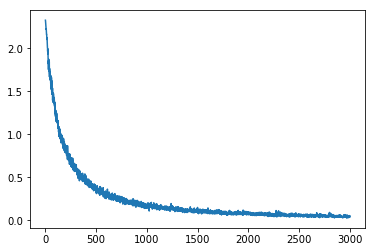

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))